# Markov Chain with Rewards

-   Note that the MDM tutorial uses discrete time discounting, so I use that here for Approach 1 and the traditional approach.
-   The 75 year horizon needs to be dealt with in approach 3.
-   Note that I zeroed out the age advancement final cell so that the results are comparable across a 75 year horizon. Need to replace to 1 if we want a full lifetime expected value.

Our final approach adapts methods from mathematical demography to estimate YLD, YLL and DALY outcomes \[@caswell2021a\].[1] This approach requires a separate disease-related absorbing state as shown in @fig-modelDS. While our focus here is on expected outcomes, this method can also be used to estimate higher order moments (e.g., variance, skewness). It is also quite flexible and can estimate separate outcomes for any combination of health states and age classes (e.g., disease-free survival among those aged 40-45, etc.); see @caswell2018 and @caswell2021a for details.

To implement Approach 3 we define some additional parameters:

$$
\begin{aligned}
\tau &= \text{Number of transient (non-absorbing) states}\\
\alpha &= \text{Number of absorbing states}\\
\omega &= \text{Number of cycles (age classes)} \\
s &= \text{Total number of states; }s=\tau\omega+\alpha \\
\mathbf{K} &= \text{vec-permutation matrix; parameters }\tau,\omega\\
\mathbf{U}_{t} &= \text{Transition matrix at time }t, \text{for }t=1,\dots,\omega\\
\mathbf{M}_{t} &= \text{Mortality matrix at time  }t, \text{for } t = 1,\dots\omega \\
\mathbf{D}_{j} &=\text{Age advancement matrix for stage }j, \text{for }j=1,\dots,\tau 
\end{aligned}
$$ In the above notation, $\mathbf{K}$ is a permutation matrix known as the vec-permutation matrix.[2] The matrix $\mathbf{U}_t$ captures transition probabilities among transient (i.e., non-absorbing) health states, while $\mathbf{M}_t$ contains transition probabilities from transient health states to the absorbing (death) states.

To construct $\mathbf{U}_t$ and $\mathbf{M}_t$ we define transition rate (“intensity”) matrices as in Approaches 1 and 2 above. One important (minor) difference is that the rows in $\mathbf{Q}_t$, $\mathbf{V}_t$, and $\mathbf{S}_t$ now correspond to the final state, while the columns correspond to the starting state; this is essentially the transpose of the rate matrices defined for Approaches 1 and 2.

The overall intensity matrix $\mathbf{Q}_t$ is given by

$$
\mathbf{Q}_t=\left(\begin{array}{c|c}
\mathbf{V}_t & \mathbf{0} \\
\hline \mathbf{S}_t  & \mathbf{0}
\end{array}\right)
$$ {#eq-Qx} where $\mathbf{V}_t$ is the rate matrix for the transitory (i.e., non-absorbing) states and $\mathbf{S}_t$ is the rate matrix for the absorbing states. The diagonal elements of $\mathbf{Q}_t$ are the negative sum of the non-diagonal column elements, thus making the column sums of $\mathbf{Q}_t$ zero (i.e., the model is “closed” and does not gain or lose cohort members over time).

For the defined time step $\Delta_t$, the discrete time transition probability matrix $\mathbf{P}_t$ is again obtained by taking the matrix exponential of the intensity matrix ($\mathbf{Q}_t$) multiplied by the time step, i.e., @eq-embed:

$$
\mathbf{P}_t =e^{\mathbf{Q}_t  \Delta t}
$$

We obtain $\mathbf{U}_t$ and $\mathbf{M}_t$ from the block matrix structure of $\mathbf{P}_t$:

$$
\mathbf{P}_t =\left(\begin{array}{c|c}
\mathbf{U}_t  & \mathbf{0} \\
\hline \mathbf{M}_t  & \mathbf{0}
\end{array}\right)
$$ {#eq-P3}

In addition, the matrix $\mathbf{D}_j$ defines age advancement in the model. Borrowing from an example in @caswell2021a, if $\omega=3$ then

$$
\mathbf{D}_j=\left(\begin{array}{ccc}
0 & 0 & 0 \\
1 & 0 & 0 \\
0 & 1 & {[1]}
\end{array}\right) \quad j=1, \ldots, \tau
$$ {#eq-D}

In our implementation, we include the (optional) value of one in the lower right corner; this assumes that after the last specified age, the cohort continues to experience transitions among health states according to the transition probabilities defined for the last age class. If this value is zero, the model will assume that everyone dies after the last cycle.

We next combine the transition matrices (for all age classes as defined by discrete time cycles) together into a series of block-structured matrices as follows:

$$
\mathbb{U}=\left(\begin{array}{c|c|c}
\mathbf{U}_1 & \cdots & \mathbf{0} \\
\hline & \ddots & \\
\hline \mathbf{0} & \cdots & \mathbf{U}_\omega
\end{array}\right)
$$ {#eq-bbU}

$$
\mathbb{D}=\left(\begin{array}{c|c|c}
\mathbf{D}_1 & \cdots & \mathbf{0} \\
\hline & \ddots & \\
\hline \mathbf{0} & \cdots & \mathbf{D}_\tau
\end{array}\right)
$$ {#eq-BBD}

$$
\widetilde{\mathbf{U}}=\mathbf{K}^{\top} \mathbb{D} \mathbf{K} \mathbb{U} \quad \tau \omega \times \tau \omega
$$ {#eq-Utilde} where $^\top$ is the transpose operator.

We also define

$$
\widetilde{\mathbf{M}}=\left(\begin{array}{lll}
\mathbf{M}_1 & \cdots & \mathbf{M}_\omega
\end{array}\right) \quad \alpha \times \tau \omega
$$ {#eq-Mtilde}

Finally, we capture the entire Markov chain in a block transition matrix,

$$
\widetilde{\mathbf{P}}=\left(\begin{array}{c|c}
\widetilde{\mathbf{U}} & \mathbf{0}_{\tau \omega \times \alpha} \\
\hline \widetilde{\mathbf{M}} & \mathbf{I}_{\alpha \times \alpha}
\end{array}\right) \quad(\tau \omega+\alpha) \times(\tau \omega+\alpha)
$$ {#eq-Ptilde} where $\mathbf{I}$ is the identity matrix and $\mathbf{0}$ is a matrix of zeros.

$\widetilde{\mathbf{P}}$ is the analogue to the transition matrix $\mathbf{P}_t$ (@eq-embed) under Approaches 1 and 2 above.

[1] The method also easily accommodates other common outcomes such as QALYs and costs.

[2] See @henderson1981 and Appendix B in @caswell2021a for further information. A function to construct a vec-permutation matrix is provided within our replication code.

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: Matrix

Attaching package: 'Matrix'

The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Attaching package: 'expm'

The following object is masked from 'package:Matrix':

    expm


Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

here() starts at /Users/johngraves/Dropbox/Projects/dalys


Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test


Attaching package: 'flextable'

The following objects are masked from 'package:kableExtra':

    as_image, footnote

The following object is masked from 'package:purrr':

    compose

In [ ]:
library(tidyverse)
library(MASS)
library(expm)
library(knitr)
library(kableExtra)
options(scipen = 5) 
transpose <- purrr::transpose
select <- dplyr::select


In [ ]:
params_ <- list(

    v_tx_names = c("SoC","A","B","AB"),        # treatment names
    n_tx = 4,                                  # number of treatment strategies
    
    cycle_correction = "half-cycle",           # cycle correction method
    #cycle_correction = "Simpson1/3", 
    
    v_tr_names = c("H","S1","S2"),             # transient health states
    v_ab_names = c("DOC","DS"),                # absorbing health states
    v_ab_names0 = c("D"),                      # absorbing health states (traditional approach)
    n_states = 5,                              # total number of health states
    n_states0 = 4,                             # total number of health states (traditional approach)
    
    horizon = 75,                             # Model time horizon (years)
    
    r_v_disc_h  = 0.03,                        # annual discount rate (health)
    r_v_disc_c = 0.03,                         # annual discount rate (costs)
    
    Delta_t = 1,                               # time step (1 = yearly)
    
    age0 = 25,                                 # age at baseline
    
    v_s0T = c(1,0,0,0,0),                      # initial state occupancy  
    v_s0T0 = c(1,0,0,0),                       # initial state occupancy (traditional approach)

    r_HS1 = 0.15,                              # disease onset rate
    r_S1H = 0.5,                               # recovery rate
    r_S1S2 = 0.105,                            # disease progression rate
    r_HD = .002,                               # background mortality rate
    
    hr_S1 = 3.0,                               # hazard rate of disease-related death from S1 state
    hr_S2 = 10.0,                              # hazard rate of disease-related death from S2 state
    
    u_H = 1,                                   # Healthy utility weight
    u_S1 = 0.75,                               # Sick utility weight
    u_S2 = 0.5,                                # Sicker utility weight
    u_D = 0,                                   # Death utility weight

    dw_S1 = 0.25,                              # Sick disability weight
    dw_S2 = 0.5,                               # Sicker disability weight
    
    c_H = 2000,                                # annual cost of healthy
    c_S1 = 4000,                               # annual cost of S1
    c_S2 = 15000,                              # annual cost of S2
    c_D = 0,                                   # annual cost of death

    c_trtA = 12000,                            # cost of treatment A
    u_trtA = 0.95,                             # utility weight for treatment A (S1 state)
    dw_trtA = 0.05,                            # Disability weight for sick under treatment A
    
    c_trtB = 13000,                            # cost of treatment B
    hr_S1S2_trtB = 0.6,                        # reduction in rate of disease progression 

    df_ExR =  
      # Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2019 
      # (GBD 2019) Reference Life Table. Institute for Health Metrics and Evaluation (IHME); 
      # 2021. doi:10.6069/1D4Y-YQ37. Accessed November 30, 2023.
          tibble::tribble(
              ~Age, ~Life.Expectancy,
              0L,       88.8718951,
              1L,      88.00051053,
              5L,      84.03008056,
              10L,      79.04633476,
              15L,       74.0665492,
              20L,      69.10756792,
              25L,      64.14930031,
              30L,       59.1962771,
              35L,      54.25261364,
              40L,      49.31739311,
              45L,      44.43332057,
              50L,      39.63473787,
              55L,      34.91488095,
              60L,      30.25343822,
              65L,      25.68089534,
              70L,      21.28820012,
              75L,      17.10351469,
              80L,      13.23872477,
              85L,      9.990181244,
              90L,      7.617724915,
              95L,      5.922359078
          ) 
)

params <- 
    with(params_,{
        modifyList(params_,list(
            v_names_states = c(v_tr_names, v_ab_names), # health state names
            omega = horizon/Delta_t,  # Total number of cycles
            r_v_disc_h_Delta_t = r_v_disc_h * Delta_t,  # Cycle discount rate: health outcomes
            r_v_disc_c_Delta_t = r_v_disc_c * Delta_t,  # Cycle discount rate: cost outcomes
            ages = (0:(horizon/Delta_t))*Delta_t + age0,  # Age in each cycle
             # Approximation function for reference life table life expectancies:
            f_ExR = function(x) pmax(0,unname(Hmisc::approxExtrap(df_ExR$Age, df_ExR$Life.Expectancy,xout = x)$y))
        ))
    })

params$ages_trace <- params$ages
params$ages <- params$ages[-length(params$ages)] 

# Discounting vectors 

v_disc_h =  # Continuous time discounting
  exp(-params$r_v_disc_h_Delta_t  * 0:(params$omega))

v_disc_c = 
  exp(-params$r_v_disc_c_Delta_t  * 0:(params$omega))

v_disc_h0 =  # Continuous time discounting
   1 / ((1 + (params$r_v_disc_h_Delta_t)) ^ (0:params$omega))

v_disc_c0 = 
   1 / ((1 + (params$r_v_disc_c_Delta_t)) ^ (0:params$omega))


In [ ]:

params_lut <- 
  list(
    "v_tx_names" = "Treatment strategies (vector)",
    "n_tx" = "Number of treatment strategies",
    "cycle_correction" = "Cycle correction method", 
    "v_tr_names" = "Transient health state names (vector)",
    "v_ab_names" = "Absorbing health state names (vector)",
    "v_ab_names0" = "Absorbing health state names (vector) - Traditional Approach",
    "n_states" = "Total number of health states",
    "n_states0" = "Total number of health states - Traditional Approach",    
    "horizon" = "Model time horizon (years)",
    "r_v_disc_h" = "Annual discount rate for health outcomes",
    "r_v_disc_c" = "Annual discount rate for cost outcomes",
    "Delta_t" = "Time step (cycle length; 1=annual, 1/12=monthly, etc.)", 
    "age0" = "Age at baseline",
    "r_HS1" = "Transition rate: healthy to sick",
    "r_S1H" = "Transition rate: sick to healthy",
    "r_S1S2" = "Transition rate: sick to sicker",
    "r_HD" = "Transition rate: Disease-free background mortality",
    "hr_S1" = "Hazard ratio: mortality from sick state",
    "hr_S2" = "Hazard ratio: mortality from sicker state", 
    "u_H" = "Utility weight: healthy [H]",
    "u_S1" = "Utility weight: sick [S1]",
    "u_S2" = "Utility weight: sick [S2]",
    "u_D" = "Utility weight: death [D]",
    "dw_S1" = "Disability weight: sick [S1]",
    "dw_S2" = "Disability weight: sicker [S2]",
    "c_H" = "Cycle occupancy cost: healthy [H]",
    "c_S1" = "Cycle occupancy cost: sick [S1]",
    "c_S2" = "Cycle occupancy cost: sicker [S2]",
    "c_D" = "Cycle occupancy cost: death [D]", 
    "c_trtA" = "Cycle occupancy cost: treatment A [S1,S2]",
    "u_trtA" = "Utility weight: treatment A [S1]",
    "dw_trtA" = "Disbility weight: treatment A [S1]",
    "c_trtB" = "Cycle occupancy cost: treatment B [S1,S2]",
    "v_s0T" = "Initial state occupancy",
    "v_s0T0" = "Initial state occupancy - Traditional Approach",
    "hr_S1S2_trtB"= "Hazard Ratio: S1 to S2 disease progression under treatment B"
  )
str_params_ <- params_ %>% map_dbl(~(length(.x)))

vec_params <- str_params_[str_params_<=5 & str_params_>1] %>% names()
vec_params <- vec_params[which(vec_params!="df_ExR")]
sc_params <- str_params_[str_params_==1] %>% names()

vec_params_ <- 
  params_[vec_params] %>% 
  map(~(paste0(.,collapse=","))) %>% 
  {glue::glue("({.})'")} 
labels_params <- intersect(names(params),c(vec_params,sc_params))

names(vec_params_) = vec_params

ft <- tibble(parameter = c(sc_params,vec_params),value = unname(c(params_[sc_params],vec_params_))) %>% 
  mutate(value = paste0(value)) %>% 
  mutate(label = paste0(factor(parameter,levels = labels_params, labels = params_lut[labels_params]))) %>% 
  mutate(parameter = factor(parameter,levels = labels_params)) %>% 
  arrange(parameter) %>% 
  rename("Parameter Name" = parameter, "Value" = value, "Description" = label) %>% 
  flextable(cwidth = 2) %>% 
  add_footer_lines("Source: Alarid-Escudero et al. (2023) and authors' assumptions.") 

ft


Parameter Name,Value,Description
v_tx_names,"(SoC,A,B,AB)'",Treatment strategies (vector)
n_tx,4,Number of treatment strategies
cycle_correction,half-cycle,Cycle correction method
v_tr_names,"(H,S1,S2)'",Transient health state names (vector)
v_ab_names,"(DOC,DS)'",Absorbing health state names (vector)
v_ab_names0,D,Absorbing health state names (vector) - Traditional Approach
n_states,5,Total number of health states
n_states0,4,Total number of health states - Traditional Approach
horizon,75,Model time horizon (years)
r_v_disc_h,0.03,Annual discount rate for health outcomes


In [ ]:
fn_r_HD <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HD <- get("r_HD", envir = parent.frame())
  r_HD
}

fn_p_HD <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HD <- get("r_HD", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-r_HD * Delta_t)
}

fn_p_S1D <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HD <- get("r_HD", envir = parent.frame())
  hr_S1 <- get("hr_S1", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-(hr_S1 * r_HD) * Delta_t)
}

fn_p_S2D <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HD <- get("r_HD", envir = parent.frame())
  hr_S2 <- get("hr_S2", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-(hr_S2 * r_HD) * Delta_t)
}

fn_r_HS1 <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HS1 <- get("r_HS1", envir = parent.frame())
  r_HS1
}

fn_p_HS1 <- function(age) {
  # Access r_HD from the parent frame where this function is called
  r_HS1 <- get("r_HS1", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-r_HS1 * Delta_t)
}

fn_r_S1H <- function(age) {
  # Access from the parent frame where this function is called
  r_S1H <- get("r_S1H", envir = parent.frame())
  r_S1H
}

fn_p_S1H <- function(age) {
  # Access from the parent frame where this function is called
  r_S1H <- get("r_S1H", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-r_S1H * Delta_t)
}

fn_r_S1S2 <- function(age) {
  # Access  from the parent frame where this function is called
  r_S1S2 <- get("r_S1S2", envir = parent.frame())
  r_S1S2
}

fn_p_S1S2 <- function(age) {
  # Access  from the parent frame where this function is called
  r_S1S2 <- get("r_S1S2", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-r_S1S2 * Delta_t)
}

fn_p_S1S2_trtB <- function(age) {
  # Access  from the parent frame where this function is called
  r_S1S2 <- get("r_S1S2", envir = parent.frame())
  hr_S1S2_trtB <- get("hr_S1S2_trtB", envir = parent.frame())
  Delta_t <- get("Delta_t", envir = parent.frame())
  1 - exp(-hr_S1S2_trtB * r_S1S2 * Delta_t)
}


In [ ]:
## Traditional Approach

params0 <- with(params,modifyList(params,list(
  # Natural History Transition Rate Matrix
  m_P = 
    ages %>% map(~({

     mP_SoC = 
          matrix(c(
          (1 - fn_p_HD(.x)) * (1 - fn_p_HS1(.x)) , (1 - fn_p_HD(.x)) * fn_p_HS1(.x)  , 0 , fn_p_HD(.x), 
          (1 - fn_p_S1D(.x)) * fn_p_S1H(.x) , (1 - fn_p_S1D(.x)) * (1 - (fn_p_S1H(.x) + fn_p_S1S2(.x))) , (1 - fn_p_S1D(.x)) * fn_p_S1S2(.x) , fn_p_S1D(.x) , 
          0 , 0 , 1 - fn_p_S2D(.x) , fn_p_S2D(.x) , 
          0,0,0,1),
          nrow = n_states0, 
          ncol = n_states0,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names0),
                          c(v_tr_names,v_ab_names0)
          ))
                          
      mP_A = 
          matrix(c(
          (1 - fn_p_HD(.x)) * (1 - fn_p_HS1(.x)) , (1 - fn_p_HD(.x)) * fn_p_HS1(.x)  , 0 , fn_p_HD(.x), 
          (1 - fn_p_S1D(.x)) * fn_p_S1H(.x) , (1 - fn_p_S1D(.x)) * (1 - (fn_p_S1H(.x) + fn_p_S1S2(.x))) , (1 - fn_p_S1D(.x)) * fn_p_S1S2(.x) , fn_p_S1D(.x) , 
          0 , 0 , 1 - fn_p_S2D(.x) , fn_p_S2D(.x) , 
          0,0,0,1),
          nrow = n_states0, 
          ncol = n_states0,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names0),
                          c(v_tr_names,v_ab_names0)
          ))    
     
      mP_B = 
          matrix(c(
          (1 - fn_p_HD(.x)) * (1 - fn_p_HS1(.x)) , (1 - fn_p_HD(.x)) * fn_p_HS1(.x)  , 0 , fn_p_HD(.x), 
          (1 - fn_p_S1D(.x)) * fn_p_S1H(.x) , (1 - fn_p_S1D(.x)) * (1 - (fn_p_S1H(.x) + fn_p_S1S2_trtB(.x))) , (1 - fn_p_S1D(.x)) * fn_p_S1S2_trtB(.x) , fn_p_S1D(.x) , 
          0 , 0 , 1 - fn_p_S2D(.x) , fn_p_S2D(.x) , 
          0,0,0,1),
          nrow = n_states0, 
          ncol = n_states0,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names0),
                          c(v_tr_names,v_ab_names0)
          ))    
          
      mP_AB = 
          matrix(c(
          (1 - fn_p_HD(.x)) * (1 - fn_p_HS1(.x)) , (1 - fn_p_HD(.x)) * fn_p_HS1(.x)  , 0 , fn_p_HD(.x), 
          (1 - fn_p_S1D(.x)) * fn_p_S1H(.x) , (1 - fn_p_S1D(.x)) * (1 - (fn_p_S1H(.x) + fn_p_S1S2_trtB(.x))) , (1 - fn_p_S1D(.x)) * fn_p_S1S2_trtB(.x) , fn_p_S1D(.x) , 
          0 , 0 , 1 - fn_p_S2D(.x) , fn_p_S2D(.x) , 
          0,0,0,1),
          nrow = n_states0, 
          ncol = n_states0,
          byrow=TRUE, 
          dimnames = list(c(v_tr_names,v_ab_names0),
                          c(v_tr_names,v_ab_names0)
          ))    
           
      array(c(as.vector(mP_SoC),
              as.vector(mP_A), 
              as.vector(mP_B),
              as.vector(mP_AB)), 
            dim = c(length(v_tr_names)+ length(v_ab_names0),length(v_tr_names)+ length(v_ab_names0),length(v_tx_names)),
            dimnames = list(c(v_tr_names,v_ab_names0),c(v_tr_names,v_ab_names0),v_tx_names)) %>% 
        apply(.,3,function(x) x, simplify=FALSE) 
      
    }))
  )))

params0$m_P <- transpose(params0$m_P); length(params0$m_P)


[1] 4

In [ ]:
params3_ <- with(params,modifyList(params1,list(
    alpha = length(v_ab_names),
    tau = length(v_tr_names), 
    s = length(v_tr_names)*omega + length(v_ab_names) #total number of states;s=τω+α
)))

# approach 3 requires us to transpose transition intensity matrices from approaches 1 & 2 
params3_ <- with(params3_,modifyList(params3_,list(
  m_R_t = m_R %>% map(~({
    tmp <- .x
    tmp %>% map(~(t(.x)))
  }))
)))

# this transpose command is not on the matrix, but on the list object; it inverts the
# nested list
params3 <- with(params3_, modifyList(params3_, list(m_R_ = m_R_t %>% transpose())))
params3$m_R = params3$m_R_

params3 <- with(params3,modifyList(params3,list(
    m_V = m_R %>% map(~({
            R = .x
            R %>% map(~({
              m <- .x[v_tr_names,v_tr_names] 
            }))
            
        })),
     
    m_Q = m_R %>% map(~({
      R = .x 
      R %>% map(~({
                V = .x[v_tr_names,v_tr_names]
                S = .x[v_ab_names,v_tr_names]
                zero_ <- matrix(0, nrow = length(v_tr_names)+length(v_ab_names), ncol = length(v_ab_names))
                tmp <- cbind(rbind(V,S),zero_)
                dimnames(tmp) <- list(c(v_tr_names,v_ab_names),c(v_tr_names,v_ab_names))
                tmp
      }))
    }))    
)))

# clear out approach 1 version
params3$m_P = NULL

params3 <- with(params3,modifyList(params3,list(
    m_P = m_Q %>% map(~({
          Q = .x
          Q %>% map(~(expm(.x * Delta_t)))
    }))
)))

params3 <- with(params3,modifyList(params3,list(
    m_U = m_P %>% map(~({
          P <- .x 
          P %>% map(~(.x[v_tr_names,v_tr_names]))
    })),
    m_M = m_P %>% map(~({
        P = .x
        P %>% map(~(.x[v_ab_names,v_tr_names]))
        
    }))
)))

params3 <- with(params3,modifyList(params3,list(
    D = {
        # Create diagonal age advancement matrix
        D <- matrix(0, omega, omega)
        vec <- rep(1, omega-1)
        D[row(D)-1 == col(D)] <- vec
        #D[omega,omega] = 1
        D
    }
)))

vec <-  # a simple function to return the vec of an array
    function(x) {
        y <- c(x)
        return(y)
    }

vecperm <- 
    # vecperm
    # function to calculate the vec permutation matrix K of index m,n
    # let X be a m x n matrix, and X' the transpose of X
    # then K satisfies 
    # vec(X') = K*vec(X)
    function(m, n) {
        K <- matrix(0, m * n, m * n)
        a <- matrix(0, m, n)
        
        for (i in 1:m) {
            for (j in 1:n) {
                e <- a
                e[i, j] <- 1
                K <- K + kronecker(e, t(e))
            }
        }
        
        return(K)
    }


params3 <- with(params3,modifyList(params3,list(
    bbD_ = kronecker(diag(tau), D),
    bbU_ =  m_U %>% 
            map(~(bdiag(.x))),
    K = vecperm(tau, omega)
)))

params3 <- with(params3,modifyList(params3,list(
    mUtilde = bbU_ %>% map( ~ ({
        t(K) %*% bbD_ %*% K %*% .x
    }))
)))

params3 <- with(params3,modifyList(params3,list(
    mMtilde = m_M %>% map(~({
      do.call(cbind,.x) 
    }))  
)))

params3 <- with(params3,modifyList(params3,list(
    mPtilde =  map2(mUtilde, mMtilde,  ~ ({
            rbind(cbind(.x, matrix(0, tau * omega, alpha)) ,
                  cbind(.y, diag(alpha)))
        }))
)))


### Years of Life Lost to Disease (YLLs): Approach 2

YLLs under Approach 2 can be calculated in a similar way as YLDs, since we have augmented the model with a transition tracking state that directly estimates new deaths in each cycle. Define the YLL payoff vector $\mathbf{d}_{YLL,t}$, which has value $Ex_{t}$ for the transition tracker health state (`trDS`) and zeros elsewhere,

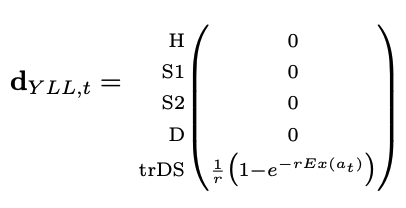{ width="40%" fig-align="center"}

We can now apply similar equations as used for YLD outcomes to calculate fully discounted YLLs,

$$
YLL=\sum_{t=0}^{\omega-1} YLL(t)=\sum_{t=0}^{\omega-1}\left(\mathbf{s}'_0 \mathbf{P}_1\mathbf{P}_2\dots\mathbf{P}_t \mathbf{d}_{YLL,t}  \times c_t \right)
$$ {#eq-yllcum}

Alternatively, using the Markov trace, we stack each $k \times 1$ payoff vector (using $\mathbf{d}_{YLL,t}^\top$ as rows) into an $\omega \times k$ payoff matrix $\mathbf{D}$, and obtain total adjusted YLLs as

$$
YLL = \sum_{t=0}^{\omega-1} \text{sum}(\mathbf{S} \odot \mathbf{D}) \odot \mathbf{c}
$$ {#eq-ylltrace} where the $\text{sum}()$ operator sums each row across the $k$ columns that result from $\mathbf{S} \odot \mathbf{D}$.

## DALY Outcomes Under Approach 3

Our advanced approach draws on Markov chain with rewards methods that define reward matrices for occupancy-based (YLD) and transition-based (YLL) outcomes. These reward matrices allow us to estimate outcomes for any combination of health states and/or ages. Reward matrices have notation $\mathbf{R}_m$, where $m$ indexes the moment of interest (e.g., expected value, variance, etc.). We focus here on expected outcomes (i.e., outcomes based on $\mathbf{R}_1$)—though equations for higher-order moments are available in @caswell2021a.

### Years of Life Lived With Disease (YLD)

To estimate YLDs, we first define a $\tau \times \omega$ reward matrix $\mathbf{H}$, which has dimensions $\tau \times \omega$ and is structured as shown in @fig-H-le:

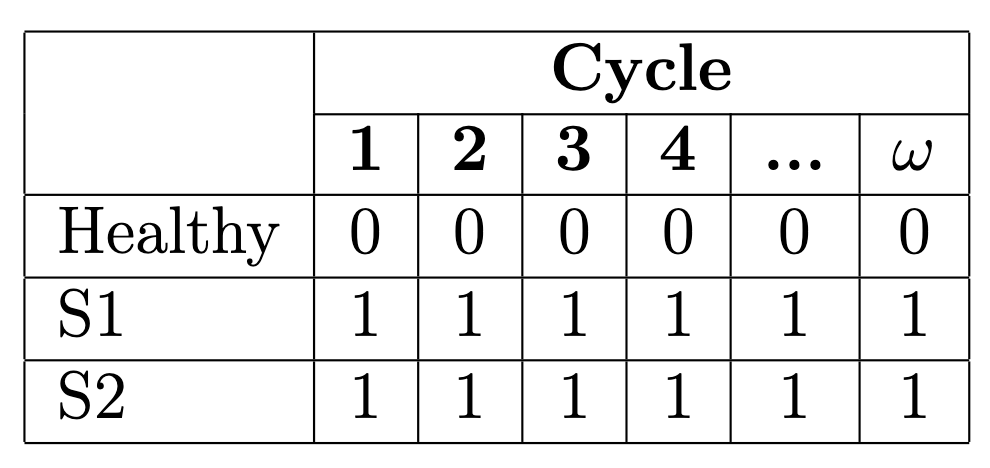{#fig-H-le fig-align="center" width="40%"}

Cell values within this matrix can be set to one if we want to potentially “reward” that health state-age combination in our outcome measure, and zero otherwise.

We use this matrix to define the reward vector $\mathbf{h}$, where $\text{vec}$ is an operator that stacks the columns of an $m \times n$ matrix into a $mn \times 1$ vector.

$$
\mathbf{h} = \text{vec } \mathbf{H}
$$ We also define $\neg \mathbf{h}$ as the complement of $\mathbf{h}$, (i.e., values of 1.0 become 0, and vice versa).

We next define additional matrix $\mathbf{V}$, which has the same structure as $\mathbf{H}$ but includes the (fully discounted) disability weights:

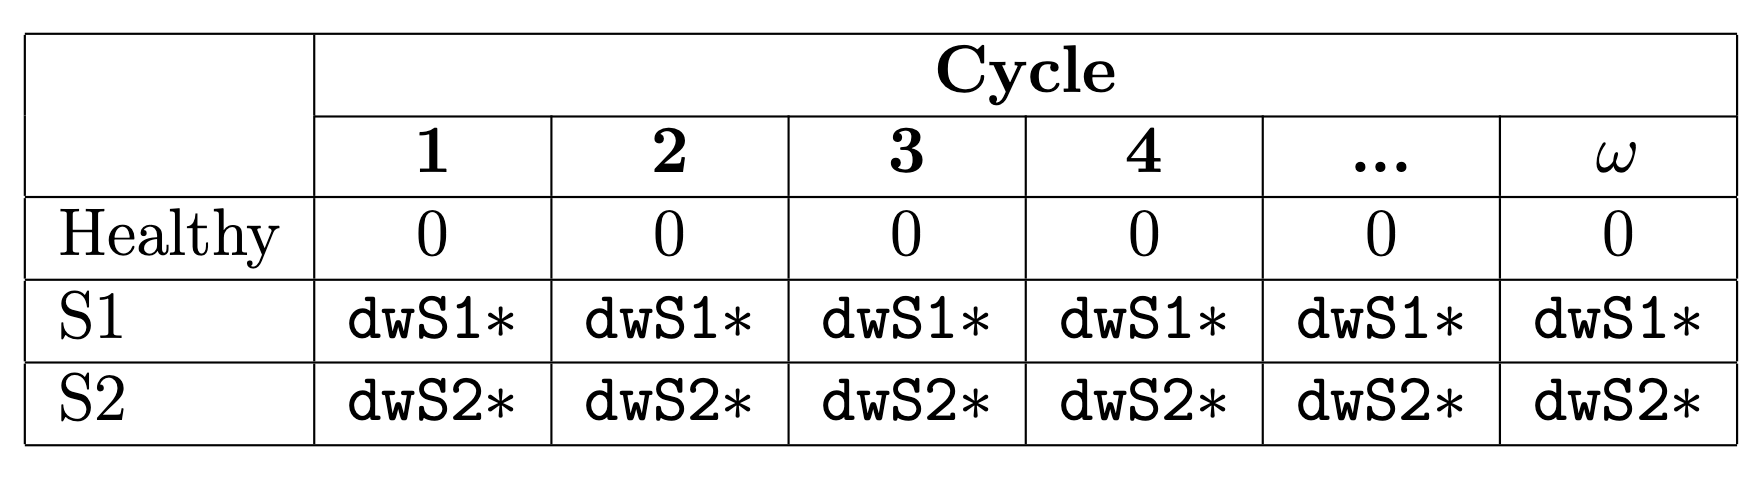{#fig-H-yld fig-align="center" width="60%"}

where $\texttt{dwS1}* = \texttt{dwS1} \times \Delta_t \times \frac{1}{r_{\Delta_t}}(1-e^{-r_{\Delta_t}}) \times e^{-r_{\Delta_t} t}$, etc. This equation first converts the weights into the appropriate value for the time step, applies the cycle-specific discounting adjustment factor, and then discounts the resulting value to the baseline period.

We similarly define an occupancy indicator vector $\mathbf{v}$ just as we did for $\mathbf{h}$:

$$
\mathbf{v}=\operatorname{vec} \mathbf{V}
$$

#### Partial Occupancy

Because we are modeling a continuous-time disease progression progress in discrete time, it is useful to make corrections for partial occupancy in a cycle. Similar to a half-cycle correction often used in health economic applications, the Markov chain with rewards approach does so by assuming transitions occur half-way through a cycle; the application of this assumption is slightly different, however, because the correction applies in every cycle, not just the first and last. We operationalize this assumption by defining,

$$
\begin{aligned}
\widetilde{\mathbf{B}}_{1} & =\mathbf{h} \mathbf{v}_{1}^{\top}+\frac{1}{2}(\neg \mathbf{h})\left(\mathbf{v}_{1}^{\top}\right)+\frac{1}{2}\left(\mathbf{v}_{1}\right)\left(\neg \mathbf{h}^{\top}\right) \\
\end{aligned}
$$ and

$$
\widetilde{\mathbf{C}}_{1}=\frac{1}{2} \mathbf{1}_{\alpha} \mathbf{v_1}^{\top}
$$ where $\mathbf{1}_{\alpha}$ is a vector of ones with length $\alpha$.

We combine $\widetilde{\mathbf{B}}_{1}$ and $\widetilde{\mathbf{C}}_{1}$ to obtain the final reward matrix for expected YLD outcomes,

$$
\widetilde{\mathbf{R}}^{YLD}_{1}=\left(\begin{array}{c|c}
\widetilde{\mathbf{B}}_{1} & \mathbf{0} \\
\hline \widetilde{\mathbf{C}}_{1} & \mathbf{0}
\end{array}\right) 
$$ which has same block structure and dimensions as the transition probability matrix $\widetilde{\mathbf{P}}$ (@eq-Ptilde). We explain how to use this matrix to estimate expected YLDs in @sec-expected below.

### Years of Life Lost to Disease (YLL)

For transition-based outcomes such as YLLs, we define the first moment of remaining life expectancy as the vector $\widetilde{\boldsymbol{\eta}}^{\top}$. This vector has dimensions $\tau\omega \times 1$ and has the following basic structure:

$$
\widetilde{\mathbf{\eta}}=\left(\begin{array}{c}
\eta_{11} \\
\vdots \\
\eta_{\tau 1} \\
\hline \vdots \\
\hline \eta_{1 \omega} \\
\vdots \\
\eta_{\tau \omega}
\end{array}\right)
$$ where $\eta_{i x}$ is remaining life expectancy for an individual in health state $i$ at a given age $x$. In this structure, remaining life expectancy for each health state is grouped within age classes. Remaining life expectancy should also enter $\eta_{i x}$ as fully discounted back to $t=0$.

Our model, for example, follows a cohort of 25 year old adults until death. The GBD reference life expectancy value for a 25 year old is 64.15, and the life expectancy for the last age class (95+) is 5.92. There are also $\tau=3$ non-absorbing health states. If we followed the cohort until age 95, $\eta_{i x}$ would take the following form:

$$
\widetilde{\mathbf{\eta}}=\left(\begin{array}{c}
\eta_{H,25} =  64.15 \\
\eta_{S1,25} =  64.15 \\
\eta_{S2,25} =  64.15 \\
\hline \vdots \\
\hline \eta_{H,95} =  5.92 \\
\eta_{S1,95} = 5.92 \\
\eta_{S2,95} =  5.92 \\
\end{array}\right)
$$

We next construct the reward matrices:

$$
\begin{aligned}
\widetilde{\mathbf{B}}_{1} & =\left(\mathbf{0}_{\tau \omega \times \tau \omega}\right) \\
\widetilde{\mathbf{C}}_{1} & =\left(\begin{array}{c}
\widetilde{\boldsymbol{\eta}}_{1}^{\top} \\
\mathbf{0}_{1 \times \tau \omega}
\end{array}\right) .
\end{aligned}
$$

and

$$
\widetilde{\mathbf{R}}^{YLL}_{1}=\left(\begin{array}{c|c}
\mathbf{0}_{\tau \omega \times \tau \omega} & \mathbf{0}_{\tau \omega \times 2} \\
\hline \widetilde{\boldsymbol{\eta}}_{1}^{\top} & \mathbf{0}_{1 \times 2} \\
\mathbf{0}_{1 \times \tau \omega} & \mathbf{0}_{1 \times 2}
\end{array}\right)
$$

### Expected YLD and YLL Outcomes

The expected value of outcome $Y$ (where $Y \in \{YLD, YLL\}$) is estimated by,

$$
\begin{aligned}
& \widetilde{\boldsymbol{\rho}}^{Y}_{1}=\widetilde{\mathbf{N}}^{\top} \mathbf{Z}\left(\widetilde{\mathbf{P}} \odot \widetilde{\mathbf{R}}^Y_{1}\right)^{\top} \mathbf{1}_{s} 
\end{aligned}
$$ {#eq-app3out} where $\widetilde{\mathbf{N}}$ is the fundamental matrix,

$$
\widetilde{\mathbf{N}}=(\mathbf{I}-\widetilde{\mathbf{U}})^{-1}
$$ and $\mathbf{Z}$ is

$$
\mathbf{Z}=\left(\mathbf{I}_{\tau \omega} \mid \mathbf{0}_{\tau \omega \times \alpha}\right)
$$

Total (across all ages) outcomes for each starting health state are calculated as

$$
\boldsymbol{\rho}_{1}^{Y,\text {stage }}(\operatorname{cycle } t)=\left(\mathbf{e}_{t}^{\top} \otimes \mathbf{I}_{\tau}\right) \widetilde{\boldsymbol{\rho}}^Y_{1} \quad \tau \times 1
$$ {#eq-app3outstate} where $\otimes$ is the Kronecker operator and $\mathbf{e}_{t}$ is a vector of length $\omega$ with a value of one in the first position and zero elsewhere; this facilitates calculating expected outcomes from the baseline period (i.e., $t=0$).

@eq-app3outstate will yield expected outcomes as typically reported in health economic evaluations. Alternatively, we may wish to calculate outcomes separately under different baseline age-health state combinations (e.g., DALYs for healthy 55 year-old adults). We obtain these expected outcomes by,

$$
\boldsymbol{\rho}_{1}^{Y,\text {age }}(\text { stage } i)=\left(\mathbf{I}_{\omega} \otimes \mathbf{e}_{i}^{\top}\right) \widetilde{\boldsymbol{\rho}}^Y_{1} \quad \omega \times 1,
$$ {#eq-app3outage} where $\mathbf{e}_{i}$ is a vector of length $\tau$ with a value of one in the initial health state position of interest (e.g., `Healthy`) and zero elsewhere.

In [ ]:
trace0 <- 
    with(params0, {
        m_P %>% map( ~ ({
            P = .x
            occ <- v_s0T0
            P %>% map(~({
              occ <<- occ %*% .x
            })) %>% 
            map(~(data.frame(.x))) %>% 
            bind_rows()
        }))
    }) 

trace1 <- 
    with(params1, {
        m_P %>% map( ~ ({
            P = .x
            occ <- v_s0T
            P %>% map(~({
              occ <<- occ %*% .x
            })) %>% 
            map(~(data.frame(.x))) %>% 
            bind_rows()
        }))
    })  


In [ ]:
# YYs
ly_ = with(params0,(matrix(c(1,
                             1 ,
                             1,
                             0) * Delta_t,
                           dimnames = list(c(
                             c(v_tr_names,v_ab_names0)
                           ), c("UW")))
))
ly_ <- 
  with(params0,{
    v_tx_names %>% map(~({
      ly_
    }))
  }) %>% 
  set_names(params0$v_tx_names)

LYt <- 
  with(params0, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T0 
      d <- ly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params0$v_tx_names)

LY = LYt %>% map(~sum(.x * gen_wcc(params0$omega, method = params0$cycle_correction))) 

# QALYs
qaly_ = with(params0,(matrix(c(u_H,
                               u_S1 ,
                               u_S2,
                               u_D) * Delta_t,
                             dimnames = list(c(
                               c(v_tr_names,v_ab_names0)
                             ), c("UW")))
))
qaly_ <- 
  with(params0,{
    v_tx_names %>% map(~({
      if (.x=="A" | .x=="AB") {
        tmp_ <- qaly_
        tmp_[2,1] = u_trtA * Delta_t
        tmp_
      } else qaly_
    }))
  }) %>% 
  set_names(params0$v_tx_names)

QALYt <-  
  with(params0, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T0
      d <- qaly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params0$v_tx_names)

QALY = QALYt %>% map(~sum(.x * v_disc_h0 * gen_wcc(params0$omega, method = params0$cycle_correction))) 

# Costs
cost_ = with(params0,(matrix(c(c_H,
                               c_S1 ,
                               c_S2,
                               c_D)*Delta_t,
                             dimnames = list(c(
                               c(v_tr_names,v_ab_names0)
                             ), c("COST")))
))
cost_ <-
  with(params0, {
    v_tx_names %>% map( ~ ({
      if (.x == "A") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA)*Delta_t
        tmp_
      } else if (.x == "B") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtB)*Delta_t
        tmp_
      } else if (.x == "AB") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA + c_trtB)*Delta_t
        tmp_
      } else cost_
    }))
  }) %>% 
  set_names(params0$v_tx_names)

COSTt <- 
  with(params0, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T0
      d <- cost_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params0$v_tx_names)

COST = COSTt %>% map(~sum(.x * v_disc_c0 * gen_wcc(params0$omega, method = params0$cycle_correction))) 

YLL <- list(NA, NA, NA, NA); names(YLL) = params0$v_tx_names
DALY = YLL
YLD = YLL
ACCDALY = YLL
QALY_DALY = YLL

result0 <- cbind(LY, YLD, YLL, DALY, ACCDALY, QALY_DALY, QALY,COST) %>%
  as.data.frame() %>%
  mutate_all( ~ as.numeric(.))  %>%
  rownames_to_column(var = "strategy") %>%
  mutate(approach = "Tutorial") %>% 
  dplyr::select(approach, strategy, everything()) 


In [ ]:
# YYs
ly_ = with(params1,(matrix(c(1,
              1 ,
              1,
              0,
              0) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
ly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
         ly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

LYt <- 
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- ly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

LY = LYt %>% map(~sum(.x * gen_wcc(params1$omega, method = params1$cycle_correction))) 

# QALYs
qaly_ = with(params1,(matrix(c(u_H,
              u_S1 ,
              u_S2,
              u_D,
              u_D) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
qaly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- qaly_
          tmp_[2,1] = u_trtA * Delta_t
          tmp_
      } else qaly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

QALYt <-  
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- qaly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

QALY = QALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 


# YLD
yld_ = with(params1,(matrix(c(0,
              dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)) ,
              dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)),
              0,
              0),
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("DW")))
))
yld_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- yld_
          tmp_[2,1] = dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
          tmp_
      } else yld_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

YLDt <- 
   with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- yld_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)
YLD = YLDt %>% map(~sum(.x*  v_disc_h[-1] * gen_wcc(params1$omega, method = params1$cycle_correction)))

# YLL
new_deaths_from_disease <- 
    map(trace1,~({
        c(0,diff(.x[,"DS"]))
    })) 

remaining_life_expectancy <- 
    with(params1,(1/r_v_disc_h) * (1 - exp(-r_v_disc_h * f_ExR(ages_trace))))
    
YLLt <- 
    new_deaths_from_disease %>% map(~(.x * remaining_life_expectancy ))

YLL <- 
    YLLt %>% map(~(sum(.x * v_disc_h * gen_wcc(params1$omega,method = params1$cycle_correction))))

DALY <- 
    map2(YLL,YLD,~(.x + .y))

# Accumulated Time in Absorbing Death State
accdaly_ = with(params1,(matrix(c(0,
              dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)) ,
              dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t)),
              0,
              1) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("UW")))
))
accdaly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- accdaly_
          tmp_[2,1] = dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
          tmp_
      } else accdaly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

ACCDALYt <- 
   with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- accdaly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)
ACCDALY = ACCDALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 

qaly_daly_ = with(params1,(matrix(c(u_H,
              1-dw_S1 ,
              1-dw_S2,
              u_D,
              u_D) * Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("QALY_DALY_")))
))
qaly_daly_ <- 
  with(params1,{
    v_tx_names %>% map(~({
        if (.x=="A" | .x=="AB") {
          tmp_ <- qaly_daly_
          tmp_[2,1] = (1-dw_trtA) * Delta_t
          tmp_
      } else qaly_daly_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

QALY_DALYt <-    
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- qaly_daly_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

QALY_DALY = QALY_DALYt %>% map(~sum(.x * v_disc_h * gen_wcc(params1$omega, method = params1$cycle_correction))) 

# Costs
cost_ = with(params1,(matrix(c(c_H,
              c_S1 ,
              c_S2,
              c_D,
              c_D)*Delta_t,
            dimnames = list(c(
                c(v_tr_names,v_ab_names)
            ), c("COST")))
))
cost_ <-
  with(params1, {
    v_tx_names %>% map( ~ ({
      if (.x == "A") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA)*Delta_t
        tmp_
      } else if (.x == "B") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtB)*Delta_t
        tmp_
      } else if (.x == "AB") {
        tmp_ <- cost_
        tmp_["S1", 1] = (c_S1 + c_trtA + c_trtB)*Delta_t
        tmp_["S2", 1] = (c_S2 + c_trtA + c_trtB)*Delta_t
        tmp_
      } else cost_
    }))
  }) %>% 
  set_names(params1$v_tx_names)

COSTt <- 
  with(params1, {
    v_tx_names %>% map( ~ ({
      P = m_P[[.x]]
      occ <- v_s0T
      d <- cost_[[.x]]
      out <- 0
      P %>% map(~({
        occ <<- occ %*% .x 
        out <<-  occ %*% d
      })) %>% 
        map(~(data.frame(.x))) %>% 
        bind_rows()
    }))
  })  %>% 
  set_names(params1$v_tx_names)

COST = COSTt %>% map(~sum(.x * v_disc_c * gen_wcc(params1$omega, method = params1$cycle_correction))) 

result1 <- cbind(LY, YLD, YLL, DALY, ACCDALY, QALY_DALY, QALY,COST) %>%
  as.data.frame() %>%
  mutate_all( ~ as.numeric(.))  %>%
  rownames_to_column(var = "strategy") %>%
  mutate(approach = "Markov Trace") %>% 
  dplyr::select(approach, strategy, everything()) 


In [ ]:
mcwr_occupancy <- function(params, H, V) {
  with(params,{
    map(v_tx_names,~({
      U = mUtilde[[.x]]
      P = mPtilde[[.x]]
      v_ = V[[.x]]
      N = solve(diag(tau*omega)-U)
      h = vec(H) %>% as.matrix()
      not_h = 1-h
      v <- vec(v_) %>% as.matrix()
      B1 <- h %*% t(v) + 0.5 * (not_h %*% t(v)) + 0.5 * (v %*% t(not_h)) # Eq. 46
      C1 = 0.5 * (rep(1,alpha) %*%  t(v)) # Eq. 48
      R1 = rbind(cbind(B1, matrix(0, tau * omega, alpha)) ,
                 cbind(C1, diag(alpha))) 
      R2 = R1 * R1
      R3 = R1 * R1 * R1
      Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
      e = rep(1,s)
      rho1_ <- t(N)%*% Z %*% t(P * R1) %*% e
      rho1_
    }))
  })
}

mcwr_yll <- function(params, life_expectancy, disc) {
  with(params,{
    map2(mUtilde,mPtilde,~({
      U = .x
      P = .y
      N = solve(diag(tau*omega)-U)
      Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
      disc_ = rev(sort(rep(disc,length(v_tr_names))))
      eta1_ex_ = rev(sort(rep(life_expectancy,length(v_tr_names))))
      eta1_ex =  eta1_ex_
      
      B1 = matrix(0,nrow=tau*omega, ncol = tau*omega)
      C1 = rbind(matrix(0,nrow=1,ncol=tau*omega),eta1_ex*disc_) 
      R1 = cbind(rbind(B1,C1),matrix(0,nrow=tau*omega+2,ncol=2))
      R2 = R1 * R1
      R3 = R1 * R1 * R1
      Z = cbind(diag(tau*omega),matrix(0,nrow=tau*omega, ncol=alpha))
      e = rep(1,s)
      rho1_ = t(N) %*% Z %*% t(.y * R1) %*% e
      rho1_
    }))
  })
}

H = with(params3,matrix(1,nrow=tau, ncol=omega))

with(params3,{
  V_LY <<- v_tx_names %>% map(~({
    v_ <- matrix(1,nrow=tau, ncol = omega) 
    v_
  })) %>% 
    set_names(v_tx_names)
})


with(params3,{
  V_YLD <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[2,] <- v_disc_h[-1]*dw_S1 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    v_[3,] <- v_disc_h[-1]*dw_S2 * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    if (.x %in% c("A","AB")) {
      v_[2,] <- v_disc_h[-1]*dw_trtA * Delta_t * (1/r_v_disc_h_Delta_t) * (1 - exp(-r_v_disc_h_Delta_t))
    }
    v_
  })) %>% 
    set_names(v_tx_names)
})

with(params3,{
  V_QALY <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[1,] <- v_disc_h[-1]*u_H * Delta_t     
    v_[2,] <- v_disc_h[-1]*u_S1 * Delta_t 
    v_[3,] <- v_disc_h[-1]*u_S2 * Delta_t 
    if (.x %in% c("A","AB")) {
      v_[2,] <- v_disc_h[-1]*u_trtA * Delta_t 
    }
    v_
  })) %>% 
    set_names(v_tx_names)
})

with(params3,{
  V_COST <<- v_tx_names %>% map(~({
    v_ <- matrix(0,nrow=tau, ncol = omega) 
    v_[1,] <- v_disc_c[-1]*c_H * Delta_t     
    v_[2,] <- v_disc_c[-1]*c_S1 * Delta_t 
    v_[3,] <- v_disc_c[-1]*c_S2 * Delta_t 
    if (.x %in% c("A")) {
      v_[2,] <- v_disc_c[-1]*(c_S1 + c_trtA) * Delta_t 
      v_[3,] <- v_disc_c[-1]*(c_S2 + c_trtA) * Delta_t  
    }
    if (.x %in% c("B")) {
      v_[2,] <- v_disc_c[-1]*(c_S1 + c_trtB) * Delta_t 
      v_[3,] <- v_disc_c[-1]*(c_S2 + c_trtB) * Delta_t  
    }    
    if (.x %in% c("AB")) {
      v_[2,] <- v_disc_c[-1]*(c_S1 + c_trtA + c_trtB) * Delta_t 
      v_[3,] <- v_disc_c[-1]*(c_S2 + c_trtA + c_trtA) * Delta_t  
    }    
    v_
  })) %>% 
    set_names(v_tx_names)
})

LY3_ <- params3 %>% mcwr_occupancy(H = H, V = V_LY)
QALY3_ <- params3 %>% mcwr_occupancy(H = H, V = V_QALY)
HYLD = H
HYLD[1,] = rep(0,ncol(H))
YLD3_ <- params3 %>% mcwr_occupancy(H = HYLD, V = V_YLD)
COST3_ <- params3 %>% mcwr_occupancy(H = H, V = V_COST)

remaining_life_expectancy <- with(params3,(1/r_v_disc_h) * (1 - exp(-r_v_disc_h * f_ExR(ages+1))))

YLL3_ <- params3 %>% mcwr_yll(life_expectancy = remaining_life_expectancy, disc = v_disc_h[-1])
DALY3_ <- map2(YLL3_,YLD3_,~(.x+.y))

LY3 <- LY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

QALY3 <- QALY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

YLD3 <- YLD3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

YLL3 <- YLL3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

DALY3 <- DALY3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

COST3 <- COST3_ %>% map(~({
  tmp <- (kronecker(t(c(1,rep(0,params3$omega-1))) ,diag(params3$tau)) %*% as.matrix(.x))
  tmp[1,1]
}))

result3 <- cbind(LY3, YLD3, YLL3, DALY3, QALY3,COST3) %>%
  as.data.frame() %>%
  rename(LY = LY3, YLD = YLD3, YLL = YLL3, DALY = DALY3, QALY = QALY3, COST = COST3) %>% 
  mutate_all( ~ as.numeric(.))  %>%
  rownames_to_column(var = "strategy") %>%
  mutate(approach = "Markov Chain With Rewards") %>% 
  dplyr::select(approach, strategy, everything())


In [ ]:
cea <- 
  bind_rows(
    dampack::calculate_icers(cost = result0$COST, effect = result0$QALY, strategies = result0$strategy) %>% 
      mutate(approach = "Traditional")
  ) %>% 
  bind_rows(
    dampack::calculate_icers(cost = result1$COST, effect = result1$QALY, strategies = result1$strategy) %>% 
      mutate(approach = "Embedded")
  ) %>% 
  bind_rows(
    dampack::calculate_icers(cost = result3$COST, effect = result3$QALY, strategies = result3$strategy) %>% 
      mutate(approach = "Matrix")
  ) %>% 
  
  mutate_at(vars(ICER,Inc_Cost,Cost), ~case_when(Status=="ND" & is.na(.)~"ref.", 
                                                  Status=="D" & is.na(.) ~ "D", 
                                                  .default=as.character(prettyNum(round(.,0), big.mark=",")))) %>% 
  mutate_at(vars(Inc_Effect,Effect), ~case_when(Status=="ND" & is.na(.)~"ref.", 
                                                  Status=="D"& is.na(.) ~ "D" , 
                                                  .default=as.character(prettyNum(round(.,2), big.mark=","))))  %>% 
  select(approach,Strategy,Cost,Inc_Cost,Effect,Inc_Effect,ICER)

cea %>% flextable()


approach,Strategy,Cost,Inc_Cost,Effect,Inc_Effect,ICER
Traditional,SoC,"152,262",ref.,21.04,ref.,ref.
Traditional,B,"259,992","107,729",22.51,1.47,"73,134"
Traditional,AB,"379,955","119,964",23.47,0.96,"125,532"
Traditional,A,"285,677",D,21.83,D,D
Embedded,SoC,"145,891",ref.,21.17,ref.,ref.
Embedded,B,"241,484","95,593",22.68,1.52,"62,922"
Embedded,AB,"350,373","108,889",23.54,0.85,"128,076"
Embedded,A,"269,368",D,21.87,D,D
Matrix,SoC,"140,717",ref.,20.92,ref.,ref.
Matrix,B,"232,415","91,698",22.38,1.46,"62,604"
